# Model fitting section

In [40]:
import gc
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import futuresalesutility as fu

In [54]:
matrix = pd.read_pickle("checkpoint_final_pruned.pkl")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")

In [55]:
matrix["first_shop_item_sale_days"] = matrix["first_shop_item_sale_days"].fillna(0).astype('int16').clip(lower=0).replace(0,9999)
matrix["first_item_sale_days"] = matrix["first_item_sale_days"].fillna(0).astype('int16').clip(lower=0).replace(0,9999)

## Split train, validation, test sets from feature matrix

In [56]:
def train_test_x_y(
    matrix, test_month, keep_from_month=3, new_target=None
):
    if new_target is not None:
        matrix["item_cnt_month"] = matrix.loc[:, new_target]
        matrix = matrix.drop(columns=new_target)

    def split_train_test(matrix, test_month=33):
        # Split the matrix into train and test sets.
        test = matrix.loc[matrix.date_block_num==test_month, :]
        train = matrix.loc[matrix.date_block_num < test_month, :]
        return train, test

    def xysplit(matrix):
        # Split a train and test set into into x and y sets, with item_cnt as the target y variable
        y = matrix.item_cnt_month
        X = matrix.drop(columns=["item_cnt_month"])
        return (X, y)

    matrix = matrix.drop(
        columns=[
            "item_revenue_month",
            "item_price",
            "item_cnt_month_original",
            "item_cnt_month_unclipped",
            "item_cnt_day_avg",
            "digital",
        ],
        errors="ignore",
    )

    train, test = split_train_test(matrix, test_month)
    train = train[train.date_block_num >= keep_from_month]
    X_train, y_train = xysplit(train)
    X_test, y_test = xysplit(test)
    return (X_train, y_train, X_test, y_test)

In [57]:
import warnings

warnings.filterwarnings("ignore", module="lightgbm")

import lightgbm as lgbm

def fit_booster(matrix, params=None, test_run = False, categoricals=[], dropcols=[], new_item_weight_factor=1):
    # Regular booster fitting function
    if params is None:
        params = {
            "boosting_type": "gbdt",
            "device_type": "cpu",
            "n_jobs": 11,
            "learning_rate": 0.1,
            "n_estimators": 20000,
            "importance_type": "gain",
        }

    if test_run:
        test_month = 34
        early_stopping_rounds=None
    else:
        test_month = 33
        early_stopping_rounds=int(1/params['learning_rate'])
    
    X_train, y_train, X_test, y_test = train_test_x_y(
        matrix.drop(columns=dropcols), test_month=test_month, keep_from_month=2,
    )
    
    if test_run:
        eval_set=[(X_train, y_train)]
    else:
        eval_set=[(X_train, y_train), (X_test, y_test)]

    booster = lgbm.LGBMRegressor(**params)
    
#     weights = (X_train['new_item'] * (new_item_weight_factor-1) + 1).to_numpy()

    booster.fit(
        X_train,
        y_train,
#         sample_weight=weights,
        eval_set=eval_set,
        eval_metric=["rmse"],
        verbose=10,
        categorical_feature=categoricals,
        early_stopping_rounds=early_stopping_rounds
    )

    if test_run:
        X_test['item_cnt_month'] = booster.predict(X_test)
        return booster, X_test
    else:
        return booster

In [58]:
matrix = matrix[selected_categoricals.to_list() + ["item_cnt_month"]]

In [60]:
gc.collect()
categoricals = [
    "item_category_id",
    "month",
    "interaction_month_item_category_id",
#     "item_name_group",
]

booster = fit_booster(matrix, test_run = False, categoricals=[], dropcols=[],new_item_weight_factor=1.0)

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.928762	training's l2: 0.862599	valid_1's rmse: 0.811616	valid_1's l2: 0.658721
[20]	training's rmse: 0.853277	training's l2: 0.728081	valid_1's rmse: 0.759951	valid_1's l2: 0.577526
[30]	training's rmse: 0.824841	training's l2: 0.680363	valid_1's rmse: 0.747161	valid_1's l2: 0.55825
[40]	training's rmse: 0.809649	training's l2: 0.655531	valid_1's rmse: 0.74073	valid_1's l2: 0.548681
[50]	training's rmse: 0.798287	training's l2: 0.637263	valid_1's rmse: 0.736539	valid_1's l2: 0.54249
[60]	training's rmse: 0.787525	training's l2: 0.620195	valid_1's rmse: 0.734398	valid_1's l2: 0.53934
[70]	training's rmse: 0.780079	training's l2: 0.608523	valid_1's rmse: 0.731573	valid_1's l2: 0.535198
[80]	training's rmse: 0.773367	training's l2: 0.598096	valid_1's rmse: 0.728182	valid_1's l2: 0.530249
[90]	training's rmse: 0.767191	training's l2: 0.588583	valid_1's rmse: 0.727512	valid_1's l2: 0.529274
[100]	training's

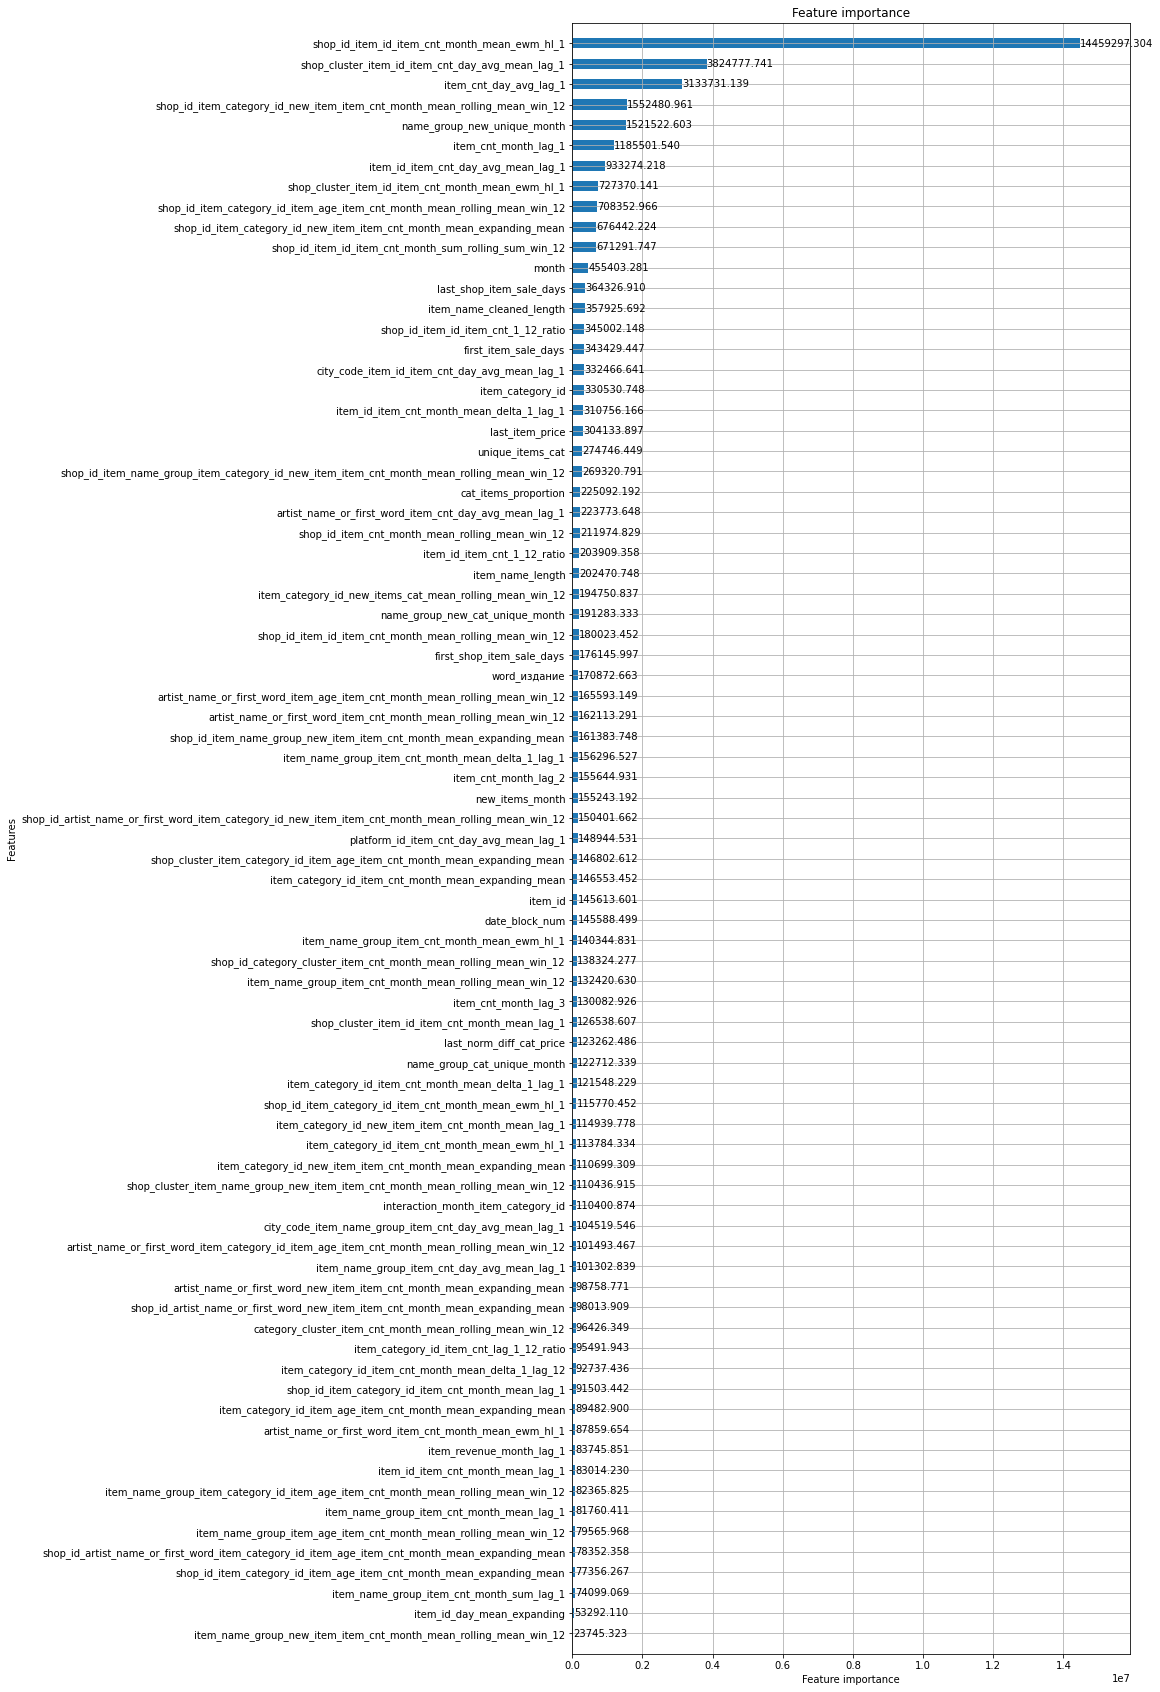

In [66]:
_ = lgbm.plot_importance(booster, figsize=(10,30), height=0.5, importance_type="gain", ignore_zero=False)

In [34]:
gc.collect()
categoricals = [
    "item_category_id",
    "month",
    "interaction_month_item_category_id",
#     "item_name_group",
]

booster = fit_booster(matrix, test_run = False, categoricals=[], dropcols=[],new_item_weight_factor=1.0)

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.928819	training's l2: 0.862705	valid_1's rmse: 0.812829	valid_1's l2: 0.660691
[20]	training's rmse: 0.852986	training's l2: 0.727585	valid_1's rmse: 0.764143	valid_1's l2: 0.583914
[30]	training's rmse: 0.825776	training's l2: 0.681906	valid_1's rmse: 0.749648	valid_1's l2: 0.561973
[40]	training's rmse: 0.811453	training's l2: 0.658455	valid_1's rmse: 0.74432	valid_1's l2: 0.554012
[50]	training's rmse: 0.799096	training's l2: 0.638555	valid_1's rmse: 0.741404	valid_1's l2: 0.549679
[60]	training's rmse: 0.78967	training's l2: 0.623579	valid_1's rmse: 0.738722	valid_1's l2: 0.54571
[70]	training's rmse: 0.780737	training's l2: 0.609551	valid_1's rmse: 0.737155	valid_1's l2: 0.543397
[80]	training's rmse: 0.774744	training's l2: 0.600228	valid_1's rmse: 0.734875	valid_1's l2: 0.540042
[90]	training's rmse: 0.768481	training's l2: 0.590563	valid_1's rmse: 0.733363	valid_1's l2: 0.537821
[100]	training'

In [51]:
gc.collect()
categoricals = [
    "item_category_id",
    "month",
    "interaction_month_item_category_id",
    "item_name_group",
]

booster = fit_booster(matrix, test_run = False, categoricals=categoricals, dropcols=dropcols,new_item_weight_factor=1.0)

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.902102	training's l2: 0.813789	valid_1's rmse: 0.816444	valid_1's l2: 0.66658
[20]	training's rmse: 0.813714	training's l2: 0.66213	valid_1's rmse: 0.765869	valid_1's l2: 0.586555
[30]	training's rmse: 0.778708	training's l2: 0.606387	valid_1's rmse: 0.751558	valid_1's l2: 0.564839
[40]	training's rmse: 0.759565	training's l2: 0.576939	valid_1's rmse: 0.746611	valid_1's l2: 0.557427
[50]	training's rmse: 0.746089	training's l2: 0.556648	valid_1's rmse: 0.744338	valid_1's l2: 0.55404
[60]	training's rmse: 0.734311	training's l2: 0.539213	valid_1's rmse: 0.739581	valid_1's l2: 0.54698
[70]	training's rmse: 0.724782	training's l2: 0.525309	valid_1's rmse: 0.738542	valid_1's l2: 0.545444
[80]	training's rmse: 0.717451	training's l2: 0.514736	valid_1's rmse: 0.737605	valid_1's l2: 0.544061
[90]	training's rmse: 0.711057	training's l2: 0.505602	valid_1's rmse: 0.737056	valid_1's l2: 0.543251
[100]	training's

In [67]:
X_train, y_train, X_test, y_test = train_test_x_y(
    matrix.drop(columns=dropcols), test_month=33, keep_from_month=2,
)

# preds = booster.predict(X_test)
# X_test['preds'] = preds
# X_test['item_cnt_month'] = y_test

In [74]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

basic = [
    "shop_id",
    "item_category_id",
    "digital",
    "platform_id",
    "city_code",
    "month",
    "year",
    "month",
    "interaction_month_item_category_id",
    "item_name_group",

]

# initialize data
# initialize Pool
train_pool = Pool(X_train, y_train, cat_features=categoricals)
test_pool = Pool(X_test, cat_features=categoricals)

# specify the training parameters
model = CatBoostRegressor(
    #     iterations=200,
    #     learning_rate=1,
    early_stopping_rounds=30,
    loss_function="RMSE",
    task_type="GPU",
)
# train the model
model.fit(
    train_pool, eval_set=(X_test, y_test),
)
# make the prediction using the resulting model
preds = model.predict(test_pool)
rmse = mean_squared_error(y_test, preds, squared=False)

print(rmse)

Learning rate set to 0.111785
0:	learn: 1.2207225	test: 1.0690061	best: 1.0690061 (0)	total: 836ms	remaining: 13m 55s
1:	learn: 1.2063901	test: 1.0576438	best: 1.0576438 (1)	total: 1.52s	remaining: 12m 39s
2:	learn: 1.1983746	test: 1.0440725	best: 1.0440725 (2)	total: 1.95s	remaining: 10m 47s
3:	learn: 1.1926779	test: 1.0398366	best: 1.0398366 (3)	total: 2.61s	remaining: 10m 50s
4:	learn: 1.1904283	test: 1.0374356	best: 1.0374356 (4)	total: 3.01s	remaining: 9m 58s
5:	learn: 1.1697629	test: 1.0222548	best: 1.0222548 (5)	total: 3.68s	remaining: 10m 9s
6:	learn: 1.1648655	test: 1.0187006	best: 1.0187006 (6)	total: 4.13s	remaining: 9m 45s
7:	learn: 1.1611276	test: 1.0162451	best: 1.0162451 (7)	total: 4.53s	remaining: 9m 21s
8:	learn: 1.1528967	test: 1.0096252	best: 1.0096252 (8)	total: 4.83s	remaining: 8m 52s
9:	learn: 1.1519650	test: 1.0085319	best: 1.0085319 (9)	total: 5.16s	remaining: 8m 30s
10:	learn: 1.1460612	test: 1.0024077	best: 1.0024077 (10)	total: 5.83s	remaining: 8m 43s
11:	lea

In [55]:
fimps = {f : i for f, i in zip(X_train.columns, booster.feature_importances_)}
import operator
sfimps = sorted(fimps.items(), key=operator.itemgetter(1))

In [60]:
drop2 = [k for k,i in sfimps[:20]]
drop2

['city_code_item_name_group_item_age_item_cnt_month_mean_rolling_mean_win_12',
 'minus1_shop_cluster_item_id_item_cnt_month_mean_lag_1',
 'city_code_artist_name_or_first_word_item_cnt_month_mean_rolling_mean_win_12',
 'category_cluster_item_cnt_month_mean_lag_1',
 'item_category_id_item_cnt_month_mean_expanding_mean',
 'shop_id_item_name_group_item_age_item_cnt_month_mean_expanding_mean',
 'word_субтитры',
 'city_code_item_cnt_month_mean_expanding_mean',
 'city_code_artist_name_or_first_word_item_age_item_cnt_month_mean_expanding_mean',
 'item_category_id_item_cnt_month_mean_rolling_mean_win_12',
 'shop_id_artist_name_or_first_word_item_age_item_cnt_month_mean_expanding_mean',
 'artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_expanding_mean',
 'item_id_item_cnt_month_mean_expanding_mean',
 'shop_id_item_id_item_cnt_month_mean_expanding_mean',
 'shop_cluster_artist_name_or_first_word_item_cnt_month_mean_expanding_mean',
 'city_code_artist_name_or_first_word_item_

In [7]:
drop1 = ['new_item',
 'shop_age',
 'new_shop',
 'platform_id',
 'artist_name_or_first_word',
 'category_cluster',
 'shop_cluster',
 '_item_cnt_month_mean_rolling_mean_win_12',
 'artist_name_or_first_word_item_age_item_cnt_month_mean_expanding_mean',
 'shop_id_item_name_group_item_cnt_month_mean_expanding_mean',
 'city_code_item_name_group_item_cnt_month_mean_rolling_mean_win_12',
 'city_code_artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean',
 'shop_cluster_artist_name_or_first_word_item_age_item_cnt_month_mean_rolling_mean_win_12',
 'shop_cluster_artist_name_or_first_word_item_age_item_cnt_month_mean_expanding_mean',
 'shop_cluster_artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean',
 'shop_cluster_item_category_id_new_item_item_cnt_month_mean_expanding_mean',
 'shop_id_item_revenue_month_mean_rolling_mean_win_12',
 'shop_id_item_category_id_item_cnt_month_mean_lag_12',
 'minus1_item_id_item_cnt_month_mean_lag_1',
 'plus1_item_id_item_cnt_month_mean_lag_1',
 'plus1_shop_cluster_item_id_item_cnt_month_mean_lag_1',
 'word_1с',
 'word_45',
 'word_fifa',
 'word_jewel',
 'word_pc',
 'word_ps3',
 'word_ps4',
 'word_store',
 'word_theft',
 'word_белый',
 'word_версия',
 'word_интерес',
 'word_карта',
 'word_оплаты',
 'word_пакет',
 'word_руб',
 'word_цифровая',
 'supercategory_id',
 'shop_id_item_category_id_item_cnt_month_mean_delta_1_lag_12']

In [8]:
drop2 = ['city_code_item_name_group_item_age_item_cnt_month_mean_rolling_mean_win_12',
 'minus1_shop_cluster_item_id_item_cnt_month_mean_lag_1',
 'city_code_artist_name_or_first_word_item_cnt_month_mean_rolling_mean_win_12',
 'category_cluster_item_cnt_month_mean_lag_1',
 'item_category_id_item_cnt_month_mean_expanding_mean',
 'shop_id_item_name_group_item_age_item_cnt_month_mean_expanding_mean',
 'word_субтитры',
 'city_code_item_cnt_month_mean_expanding_mean',
 'city_code_artist_name_or_first_word_item_age_item_cnt_month_mean_expanding_mean',
 'item_category_id_item_cnt_month_mean_rolling_mean_win_12',
 'shop_id_artist_name_or_first_word_item_age_item_cnt_month_mean_expanding_mean',
 'artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_expanding_mean',
 'item_id_item_cnt_month_mean_expanding_mean',
 'shop_id_item_id_item_cnt_month_mean_expanding_mean',
 'shop_cluster_artist_name_or_first_word_item_cnt_month_mean_expanding_mean',
 'city_code_artist_name_or_first_word_item_cnt_month_mean_ewm_hl_1',
 'shop_cluster_item_name_group_item_cnt_month_mean_ewm_hl_1',
 'shop_id_item_category_id_item_cnt_month_mean_delta_1_lag_1',
 'shop_cluster_item_name_group_item_age_item_cnt_month_mean_expanding_mean',
 'shop_cluster_item_name_group_item_cnt_month_mean_rolling_mean_win_12']

In [9]:
dropcols = drop1 + drop2

In [11]:
X_train, y_train, X_test, y_test = train_test_x_y(
    matrix.drop(columns=drop1), test_month=34, keep_from_month=2,
)

In [49]:
from sklearn.feature_selection import RFECV

def time_split(start_date_block, last_date_block, df):
    for test_date_block in range(start_date_block, last_date_block + 1):
        train_idx = df["date_block_num"] < test_date_block
        test_idx = df["date_block_num"] == test_date_block
        yield train_idx, test_idx

# X_train, y_train, X_test, y_test = train_test_x_y(
#     matrix.drop(columns=dropcols), test_month=34, keep_from_month=2,
# )
# del(X_test, y_test)

categoricals = [
    "item_category_id",
    "month",
    "interaction_month_item_category_id",
    "item_name_group",
]

X_train[categoricals] = X_train[categoricals].astype("category")

start_date_block = 33
last_date_block = 33

ts = time_split(start_date_block, last_date_block, X_train)
params = {
    "boosting_type": "gbdt",
    "device_type": "cpu",
    "n_jobs": 11,
    "learning_rate": 0.1,
    "n_estimators": 100,
    "importance_type": "gain",
}
booster = lgbm.LGBMRegressor(**params)
selector = RFECV(booster, step=1, cv=ts, scoring =  'neg_root_mean_squared_error')
selector = selector.fit(X_train, y_train)

selector.ranking_

C:\Users\grant\anaconda3\envs\predsales\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([  1, 101,   1,  87,   1,   1,   1,  29,   1, 129,   1,   6,  47,
         1,   1, 135,  59,   1,   1,  19,   1,   1,   1,   1,   5,   1,
        12,   1,  20,  33,   1,  92,   1,  98,   1,  64,   1,  36,   1,
         1,  90,  40,  58,  73,  27,   1,  46,  26, 111,  48,   1,   1,
        91,  44,   1, 142,  17,  13, 140, 107,  84, 134, 136,  66,   1,
         1,  38,   1, 120,  34,  31,   1,  42,   1,   1,   1,   1,   1,
        30,  32,   1,   1,  52,   3,  89,   1,   1,   1,  69,  23,  60,
         1,  74,  53, 104,   1,  41, 130,   1, 138, 125,   1, 116, 133,
         1,  14,  82,   1,   1,   1,   1, 108, 124, 131, 122, 115,  25,
       102,  61,  96, 126, 143, 141,  71,  93, 119, 117, 113,  65, 109,
        80, 137, 114, 128,  45,  86,  99, 112,  75,  35,  95,   1,  54,
        68, 110,  67,  70,  62,   1,   1,  15, 121,  22,   1,  43, 127,
       103,  76,  21,   2,   1, 100,   7,  16,  57,  28,  85,   1,   1,
         1,   1,   1,   1,   9,   1,   1, 106,   1,  94,  79,   

In [50]:
selector.support_

array([ True, False,  True, False,  True,  True,  True, False,  True,
       False,  True, False, False,  True,  True, False, False,  True,
        True, False,  True,  True,  True,  True, False,  True, False,
        True, False, False,  True, False,  True, False,  True, False,
        True, False,  True,  True, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True, False, False, False,  True,  True,  True, False, False,
       False,  True, False, False, False,  True, False, False,  True,
       False, False,  True, False, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [53]:
dropped = X_train.columns[~selector.support_]
dropped

Index(['shop_id', 'shop_open_days', 'last_item_sale_days', 'item_age',
       'last_norm_diff_exp_mean_price', 'last_norm_diff_start_price',
       'city_code', 'item_name_group', 'name_group_unique_month',
       'unique_items_month',
       ...
       'minus1_item_id_item_cnt_month_mean_rolling_mean_win_12',
       'plus1_item_id_item_cnt_month_mean_rolling_mean_win_12',
       'minus1_shop_cluster_item_id_item_cnt_month_mean_lag_1', 'word_auto',
       'word_edition', 'word_playstation', 'word_sims', 'word_русская',
       'word_русские', 'word_субтитры'],
      dtype='object', length=142)

In [52]:
len(selected_categoricals)

79

In [14]:
selected = X_train.columns[selector.support_]
selected

Index(['date_block_num', 'item_id', 'first_item_sale_days',
       'first_shop_item_sale_days', 'last_shop_item_sale_days', 'month',
       'last_item_price', 'last_norm_diff_cat_price', 'item_category_id',
       'item_name_length', 'item_name_cleaned_length',
       'name_group_cat_unique_month', 'name_group_new_unique_month',
       'name_group_new_cat_unique_month', 'unique_items_cat',
       'unique_items_month', 'cat_items_proportion', 'new_items_month',
       'item_id_item_cnt_month_mean_delta_1_lag_1',
       'item_name_group_item_cnt_month_mean_delta_1_lag_1',
       'item_category_id_item_cnt_month_mean_delta_1_lag_12',
       'shop_id_item_name_group_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12',
       'shop_id_artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12',
       'shop_id_artist_name_or_first_word_item_category_id_item_age_item_cnt_month_mean_expanding_mean',
       'item_name_group_item_category_id_item_

In [44]:
selector_no_categoricals = selector

In [38]:
selected_no_categorical = selected.copy()

In [33]:
import shap

All-NaN slice encountered
invalid value encountered in true_divide


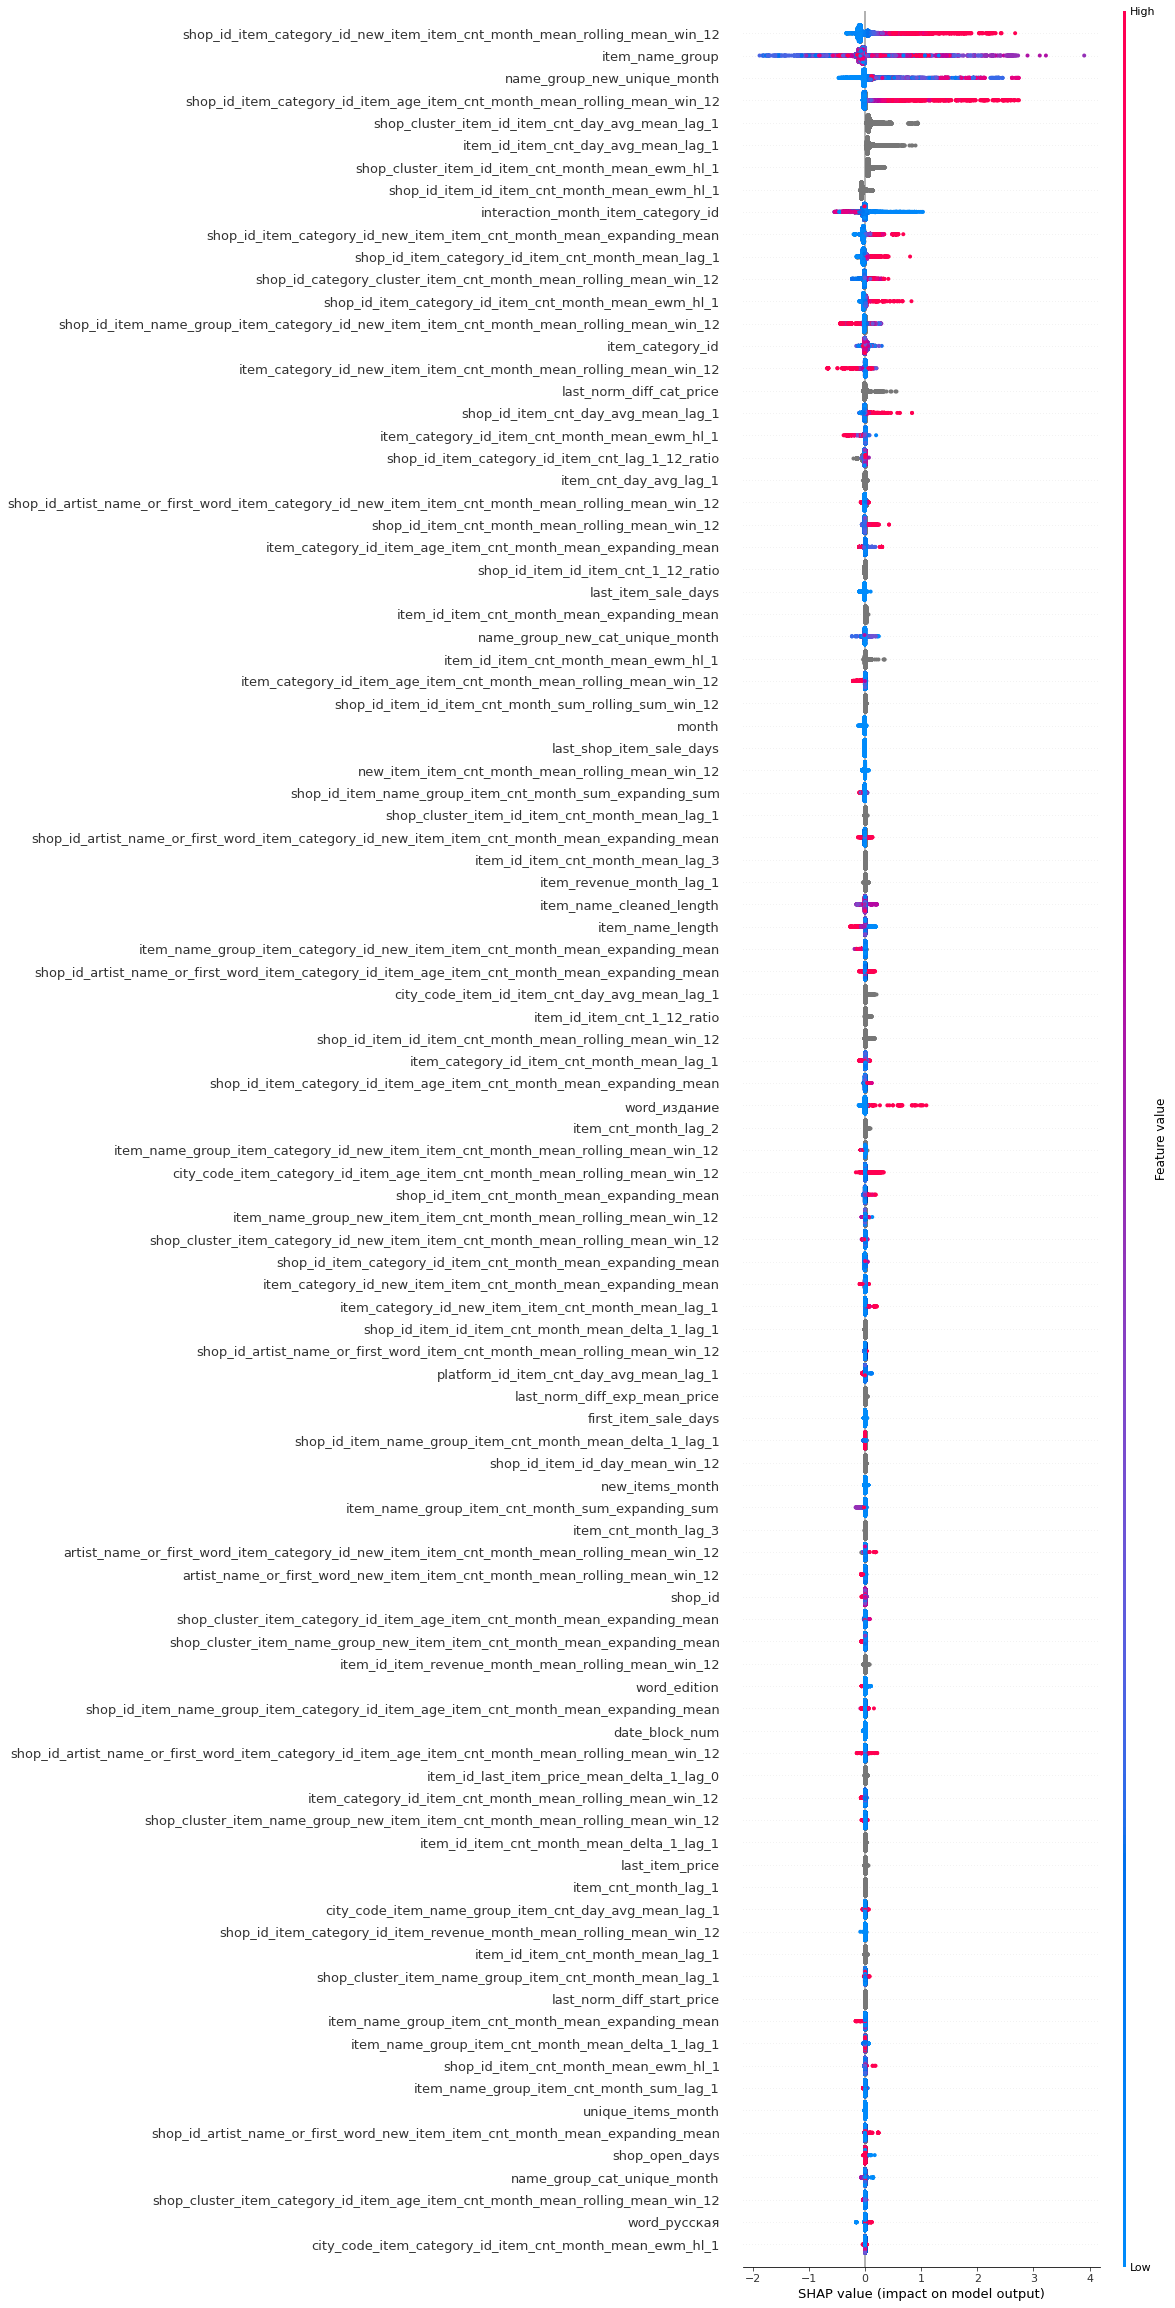

In [34]:
temp = X_test.drop(columns=['preds', 'item_cnt_month']).query("item_age==0")
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(temp)
shap.summary_plot(shap_values, temp, max_display=100)

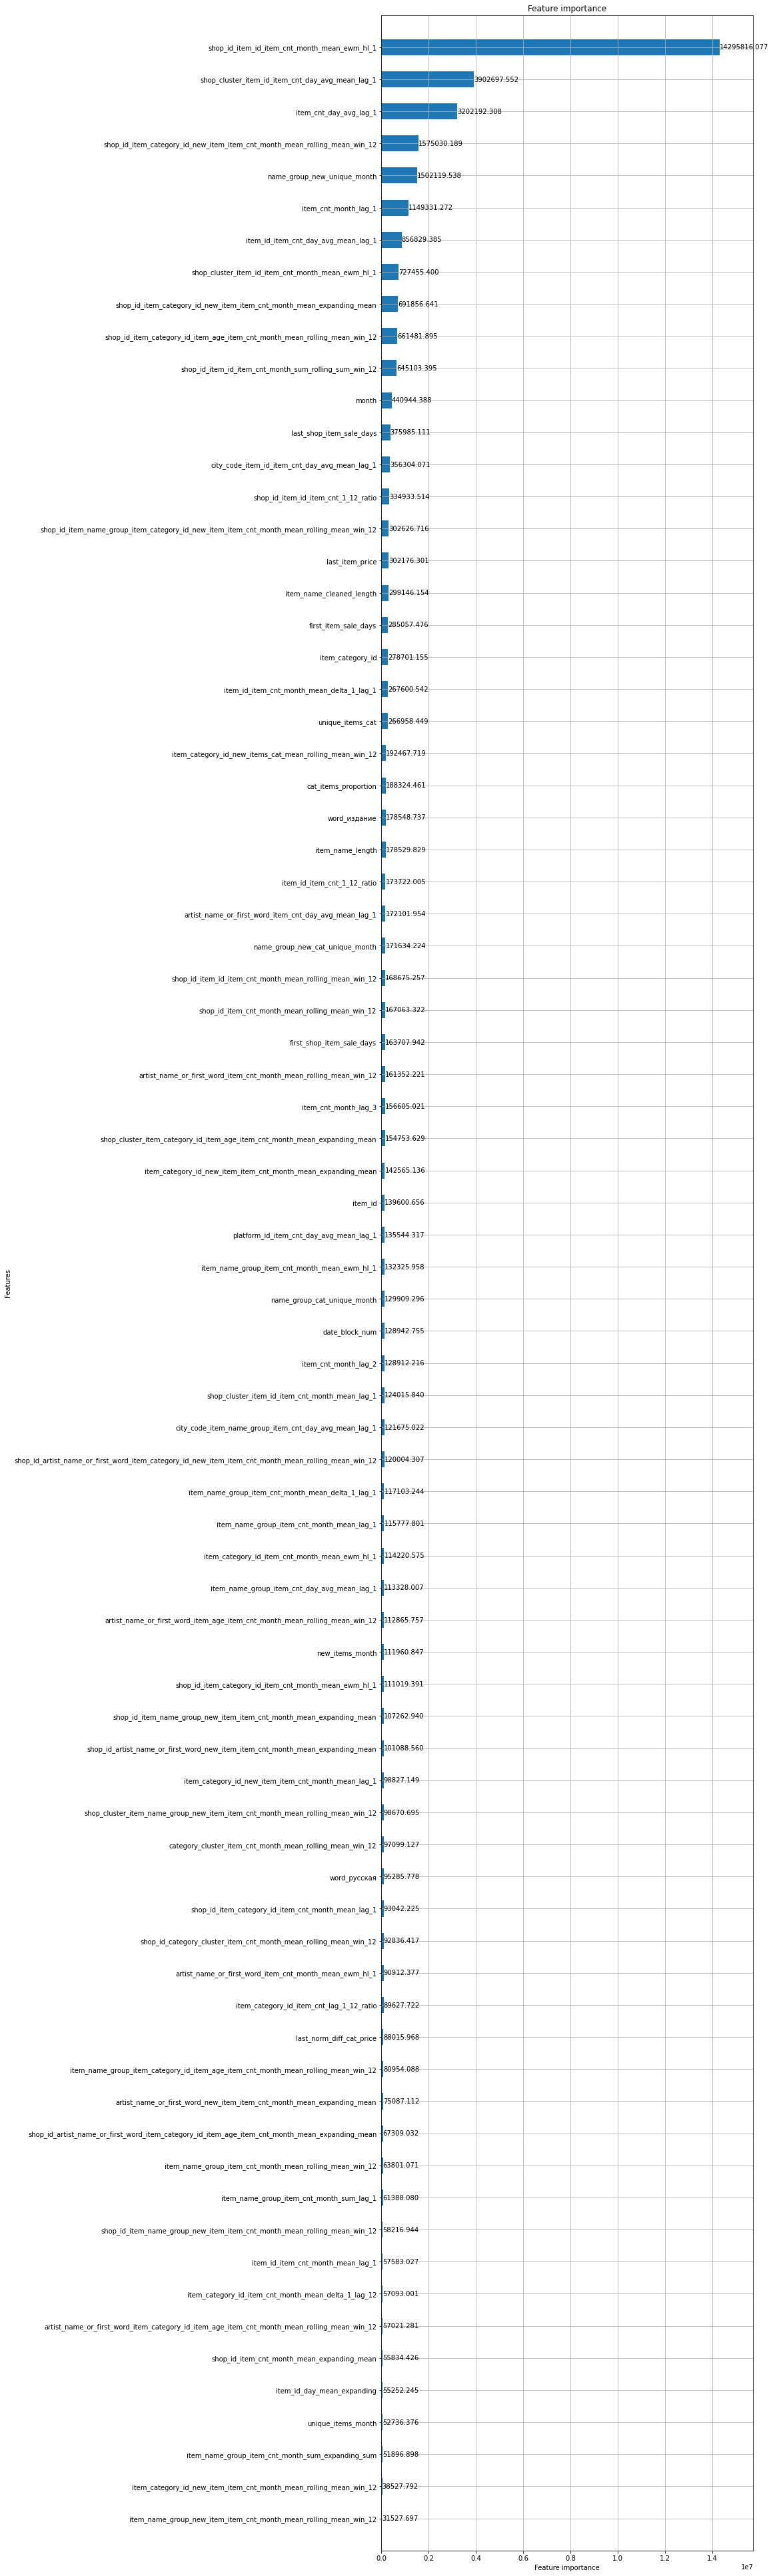

In [35]:
_ = lgbm.plot_importance(booster, figsize=(10,70), height=0.5, importance_type="gain", ignore_zero=False)

In [ ]:
categoricals = [
    "item_category_id",
    "month",
    "interaction_month_item_category_id",
    "item_name_group",
]
# categoricals = ['shop_id', 'month', 'category_id', 'shop_city']
dropcols=[]

booster = fit_booster(df, test_run = False, categoricals=categoricals, dropcols=dropcols)

In [ ]:
_ = lgbm.plot_importance(booster, figsize=(10,70), height=0.5, importance_type="gain", ignore_zero=False)

In [ ]:
categoricals = [
    "item_category_id",
    "month",
#     "interaction_month_item_category_id",
    "item_name_group",
]
# categoricals = ['shop_id', 'month', 'category_id', 'shop_city']
dropcols=['shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12_ns']

booster = fit_booster(matrix, test_run = False, categoricals=categoricals, dropcols=dropcols)

In [ ]:
_ = lgbm.plot_importance(booster, figsize=(10,70), height=0.5, importance_type="gain", ignore_zero=False)

In [ ]:
matrix.columns.to_list()

In [ ]:
import xgboost as xgb
X_train, y_train, X_test, y_test = train_test_x_y(
    matrix.drop(columns=[]), test_month=33, keep_from_month=2,
)
xgbooster = xgb.XGBRegressor()
xgbooster = xgbooster.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse",
        eval_set=[(X_test, y_test)])

Validation RMSE from selected features without categoricals was [64] 0.73328

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

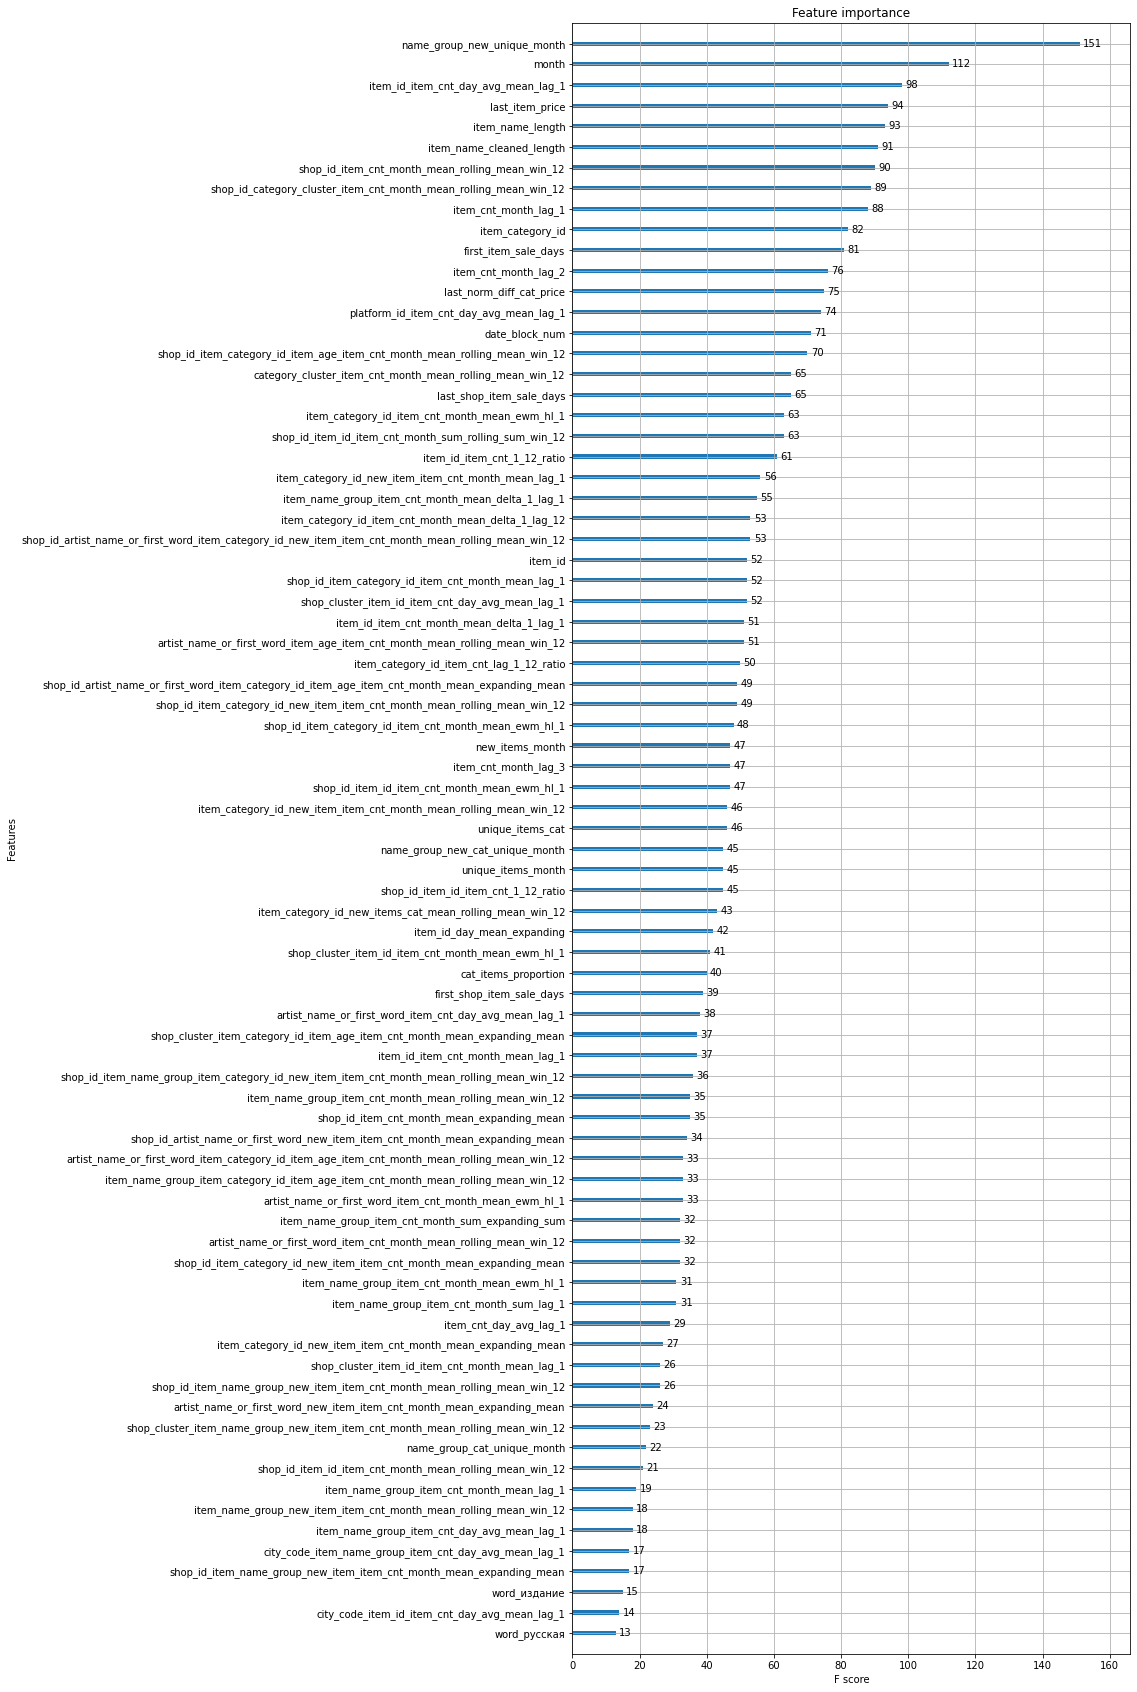

In [37]:
fig, ax = plt.subplots(figsize=(10,30))
xgb.plot_importance(xgbooster, ax=ax)

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error

import lightgbm as lgbm

class Objective(object):
    def __init__(self, matrix):
        matrix = censor_lag_features(matrix, matrix.columns, replacement_val=9999)
        self.X_train, self.y_train, self.X_valid, self.y_valid = train_test_x_y(
            matrix, test_month=33, keep_from_month=2,
            )

    def __call__(self, trial):
        params = {
            "boosting_type": "gbdt",
            "device_type": "cpu",
            "n_jobs": 11,
            "silent": True,
            "n_estimators": 1000,
            "learning_rate": 0.1,
            "subsample_for_bin": 300000,
            "max_depth": -1,
            "min_data_in_bin": 1,
            "num_leaves": trial.suggest_int("num_leaves", 255, 2048, log=True),
            "cat_smooth": trial.suggest_float("cat_smooth", 10, 100, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 20),
            "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 2, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 8),
            "max_bin": trial.suggest_int("max_bin", 128, 1024, log=True),
        }
        
        categoricals = [
            "item_category_id",
            "month",
            "item_name_group",
            "interaction_month_item_category_id"
        ]
               
        categoricals = [c for c in categoricals if c in self.X_train.columns]
        
        early_stopping_rounds=int(1/params['learning_rate'])
        
        # Add a callback for pruning.
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")

        booster = lgbm.LGBMRegressor(**params)

        booster.fit(
            self.X_train,
            self.y_train,
            eval_set=[(self.X_valid, self.y_valid)],
            eval_metric=["rmse"],
            callbacks=[pruning_callback],
            verbose=False,
            categorical_feature=categoricals,
            early_stopping_rounds=early_stopping_rounds
            
        )

        predictions = booster.predict(self.X_valid)
        rmse = mean_squared_error(self.y_valid, predictions.clip(0,20), squared=False)

        return rmse


import warnings

# warnings.filterwarnings("ignore", message="", module="lightgbm", lineno=1286)
warnings.filterwarnings("ignore", message="", module="lightgbm")

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=15), direction="minimize")
study.optimize(Objective(matrix), n_trials=300, gc_after_trial=True)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
import joblib
from datetime import datetime
fname = f'optuna_results_{datetime.now().strftime("%Y%m%d_%H%M")}.pk1'
joblib.dump(study, fname)

In [ ]:
import joblib
# filename = 'optuna_results_20210325_1937.pk1'
study = joblib.load(fname)

In [ ]:
best_params = study.best_params

for k in ["interaction_month_digital_categorical", "interaction_month_item_category_id_categorical"]:
    best_params.pop(k, None)

other_params = {
    "boosting_type": "gbdt",
    "device_type": "cpu",
    "n_jobs": 11,
    "silent": True,
    "n_estimators": 10000,
    "learning_rate": 0.1,
    "bagging_seed": 3,
    "subsample_for_bin": 300000,
    "max_depth": -1,
    "min_data_in_bin": 1,
}

best_params = {**best_params, **other_params}

categoricals = [
    "item_category_id",
    "month",
    "artist_name_or_first_word",
]
if best_params["interaction_month_digital_categorical"]:
    categoricals = categoricals + ["interaction_month_digital"]
if best_params["interaction_month_item_category_id_categorical"]:
    categoricals = categoricals + ["interaction_month_item_category_id"]

booster = fit_booster(matrix, params=best_params, test_run = False, categoricals=categoricals, dropcols=[])

In [ ]:
print("finished everything!")

In [ ]:
def plot_correlation_mat(cm, title='Feature correlations', figsize=(50,50)):
    fig, ax = plt.subplots(figsize=figsize)
    axsubplot = sns.heatmap(cm, annot=True, ax=ax)
    fig.tight_layout()

cm = matrix.corr()
plot_correlation_mat(cm)

In [ ]:
# Create correlation matrix
corr_matrix = matrix.corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [ ]:
# Drop Marked Features
# Drop features 
df.drop(df[to_drop], axis=1)

In [ ]:
from optuna import importance
import optuna.visualization as oviz

# importance.get_param_importances(study, evaluator=importance.FanovaImportanceEvaluator())
# importance.get_param_importances(study, evaluator=importance.MeanDecreaseImpurityImportanceEvaluator())
# oviz.plot_param_importances(study, evaluator=importance.MeanDecreaseImpurityImportanceEvaluator())
oviz.plot_param_importances(study, evaluator=importance.FanovaImportanceEvaluator())

In [ ]:
oviz.plot_optimization_history(study)